In [22]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
import itertools
import random
import psutil

In [2]:
RAWDATA_PATH = r'./donateacry-corpus/donateacry_corpus_cleaned_and_updated_data/'
DATASETS_PATH = r'./datasets_aug'

In [3]:
wav_count = 0
for _, _, files in os.walk(RAWDATA_PATH):
    for file in files:
        if file.lower().endswith('.wav'):
            wav_count += 1
print(f'Total number of WAV files: {wav_count}')

Total number of WAV files: 457


sr: min = 8000 Hz, max = 8000 Hz
len: min = 6.52 sec, max = 7.06 sec


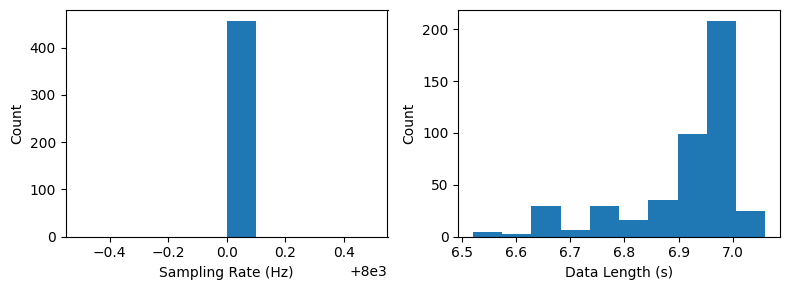

In [4]:
# データのsrや長さの確認
sr_list = []
len_list = []
for current, _, files in os.walk(RAWDATA_PATH):
    for file in files:
        if file.lower().endswith('.wav'):
            y, sr = librosa.load(os.path.join(current, file), sr=None)
            sr_list.append(sr)
            len_list.append(len(y))

sr_list = np.array(sr_list)
len_list = np.array(len_list)
len_list_sec = len_list / sr_list
print(f'sr: min = {np.min(sr_list)} Hz, max = {np.max(sr_list)} Hz')
print(f'len: min = {np.min(len_list_sec)} sec, max = {np.max(len_list_sec)} sec')

plt.figure(figsize=(8, 3))

plt.subplot(1, 2, 1)
plt.hist(sr_list)
plt.ylabel('Count')
plt.xlabel('Sampling Rate (Hz)')

# 2つ目のヒストグラム
plt.subplot(1, 2, 2)
plt.hist(len_list / sr_list)
plt.ylabel('Count')
plt.xlabel('Data Length (s)')

# グラフを表示
plt.tight_layout()
plt.show()

一旦、単純にCNNにぶっ込んでみる。  
必要な工程は以下。  
- データ整形 (長さ揃える、メルスペクトログラムにする)
- CNN設計

その後の展望としては以下。
- 性別とか年齢の情報は使えないか？
- data augumentation。それにあたってまず分類に相関の少ない特徴量を特定したい。
- 音声の時点でtrain/testに分割。trainに対して、時間方向の平行移動、ノイズ付加、音量の増減。

いろんなハイパラで回して、それぞれのプロットとモデルを保存する。そんなん転がってそう。

In [5]:
def aug_with_noise(y):
    noise_amplitude = 0.05 * np.std(y)
    noise = noise_amplitude * np.random.randn(len(y))
    return y + noise


def aug_with_gain(y):
    max_amplitude = np.max(np.abs(y))
    safe_gain = 1.0 / max_amplitude if max_amplitude > 0 else 1.0
    gain = np.random.uniform(0, safe_gain)
    return y * gain


def aug_with_shift(y):
    threshold = np.max(np.abs(y)) / 10
    silent_indices = np.where(np.abs(y) < threshold)[0]

    shift_direction = np.random.choice(['left', 'right'])
    diffs = np.diff(silent_indices)
    if shift_direction == 'left':
        end_of_segments = np.where(diffs != 1)[0]
    else:
        end_of_segments = np.where(diffs != 1)[-1]

    if len(end_of_segments) > 0:
        max_index = silent_indices[end_of_segments[0]]
    elif len(end_of_segments) == 0:
        max_index = 0
    else:
        max_index = silent_indices[-1]

    if shift_direction == 'left':
        shift_amount = np.random.randint(1, max_index + 1)
        y_shifted = np.roll(y, -shift_amount)
        y_shifted[-shift_amount:] = 0
    else:
        shift_amount = np.random.randint(1, max_index + 1)
        y_shifted = np.roll(y, shift_amount)
        y_shifted[:shift_amount] = 0

    return y_shifted


def save_mel_spectrogram(y, save_file_name, aug_funcs):
    for aug_func in aug_funcs:
        y = aug_func(y)
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    mel_spectrogram = cv2.normalize(mel_spectrogram, None, 0, 255, cv2.NORM_MINMAX)
    mel_spectrogram = mel_spectrogram.astype(np.uint8)
    cv2.imwrite(save_file_name, mel_spectrogram)

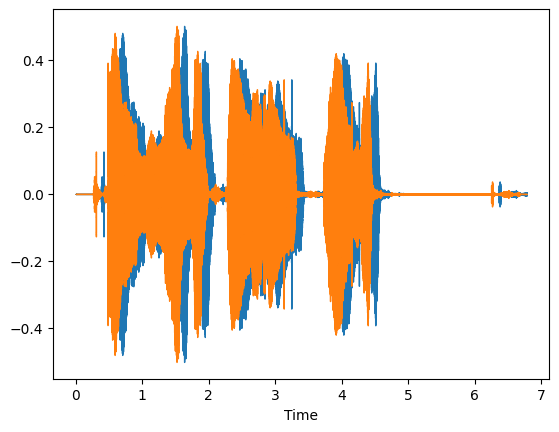

In [6]:
# aug_with_shift関数の実行確認
is_first = True
y, sr = None, None
for current, _, files in os.walk(RAWDATA_PATH):
    for file in files:
        if file.lower().endswith('.wav'):
            y, sr = librosa.load(os.path.join(current, file), sr=None)

# threshold = 0.01
threshold = np.max(np.abs(y)) / 10
silent_indices = np.where(np.abs(y) < threshold)[0]
librosa.display.waveshow(y, sr=sr)
librosa.display.waveshow(aug_with_shift(y), sr=sr)

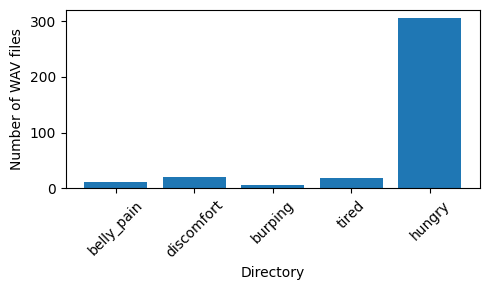

In [7]:
wav_file_counts = {}

for class_name in os.listdir(os.path.join(DATA_PATH, 'train')):
    class_name_path = os.path.join(os.path.join(DATA_PATH, 'train'), class_name)
    if os.path.isdir(class_name_path):
        wav_count = sum(1 for file in os.listdir(class_name_path) if file.lower().endswith('.wav'))
        wav_file_counts[class_name] = wav_count

fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(wav_file_counts.keys(), wav_file_counts.values())
ax.set_xlabel('Directory')
ax.set_ylabel('Number of WAV files')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [24]:
# データ整形
# 具体的には、音声の長さを揃えて(末尾を0埋め)、メルスペクトログラムにする
# torchvision.datasets.ImageFolder の形式に沿ってデータセットを構築

train_dir = os.path.join(DATASETS_PATH, 'train')
val_dir = os.path.join(DATASETS_PATH, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

target_size = np.max(len_list)
print(f'target size: {target_size}')

aug_funcs = [aug_with_noise, aug_with_gain, aug_with_shift]
all_combi_of_aug_funcs = []
for r in range(1, len(aug_funcs) + 1):
    combinations_r = list(itertools.combinations(aug_funcs, r))
    all_combi_of_aug_funcs.extend(combinations_r)

TRAIN_DATA_PER_CLASS = 5000
aug_ratio_dict = {label: TRAIN_DATA_PER_CLASS // num for label, num in wav_file_counts.items()}

with ThreadPoolExecutor(max_workers=psutil.cpu_count(logical=False) - 2) as executor:
    for class_name in os.listdir(RAWDATA_PATH):
        class_path = os.path.join(RAWDATA_PATH, class_name)
        if not os.path.isdir(class_path):
            continue

        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        
        wav_files = os.listdir(class_path)
        train_files, val_files = train_test_split(wav_files, test_size=0.2, random_state=42)

        for save_dir, files in {train_class_dir: train_files, val_class_dir: val_files}.items():
            for file in files:
                if file.lower().endswith('.wav'):
                    y, sr = librosa.load(os.path.join(class_path, file), sr=None)
                    original_size = len(y)
                    if original_size < target_size:
                        formatted_y = np.zeros(target_size, dtype=y.dtype)
                        formatted_y[:original_size] = y
                    else:
                        formatted_y = y
                    
                    if save_dir == train_class_dir:
                        for i in range(aug_ratio_dict[class_name]):
                            executor.submit(
                                save_mel_spectrogram,
                                formatted_y,
                                os.path.join(save_dir, '.'.join(file.split('.')[:-1]) + f'_{i}' + '.png'),
                                random.choice(all_combi_of_aug_funcs)
                            )
                    else:
                        executor.submit(
                            save_mel_spectrogram,
                            formatted_y,
                            os.path.join(save_dir, '.'.join(file.split('.')[:-1]) + '.png'),
                            [lambda x: x, ]
                        )

target size: 56480


In [25]:
wav_count = 0
for _, _, files in os.walk(DATASETS_PATH):
    for file in files:
        if file.lower().endswith('.png'):
            wav_count += 1
print(f'Total number of PNG files: {wav_count}')

Total number of PNG files: 24959


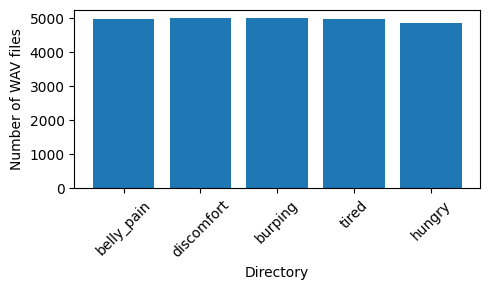

In [28]:
png_file_counts = {}

for class_name in os.listdir(os.path.join(DATASETS_PATH, 'train')):
    class_name_path = os.path.join(os.path.join(DATASETS_PATH, 'train'), class_name)
    if os.path.isdir(class_name_path):
        wav_count = sum(1 for file in os.listdir(class_name_path) if file.lower().endswith('.png'))
        png_file_counts[class_name] = wav_count

fig, ax = plt.subplots(figsize=(5, 3))
ax.bar(png_file_counts.keys(), png_file_counts.values())
ax.set_xlabel('Directory')
ax.set_ylabel('Number of WAV files')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()